## Smoothing and enhancing spatial features using Smoother-guided imputation (Fig S4 and S5)

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy
import seaborn as sns

from smoother import SpatialWeightMatrix, SpatialLoss
from smoother.models.impute import ImputeTorch, ImputeConvex

import scanpy as sc

In [2]:
data_dir = "/Users/jysumac/Projects/Smoother_paper/data/sodb_samples/visium_normal/" + \
    "10X_Visium_maynard2021trans_151673_data.h5ad"

### Load the brain cortex dataset (151673)

In [3]:
data = sc.read_h5ad(data_dir)
data.layers['raw'] = data.X.copy()

#### Preprocessing

In [4]:
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data)
sc.tl.rank_genes_groups(data, 'Region', method='wilcoxon')

#### Calculate layer signature scores

In [5]:
df_marker = sc.get.rank_genes_groups_df(data, group = None, pval_cutoff=0.05)
df_marker = df_marker.sort_values("logfoldchanges", ascending=False).groupby('group').head(20)

group_names = df_marker['group'].unique()
for g in group_names:
    sc.tl.score_genes(data, df_marker['names'][df_marker['group'] == g], score_name=f'{g}_score')
    #data.obs[f'{g}_score'] = data[:, df_marker['names'][df_marker['group'] == g]].layers['raw'].sum(1)

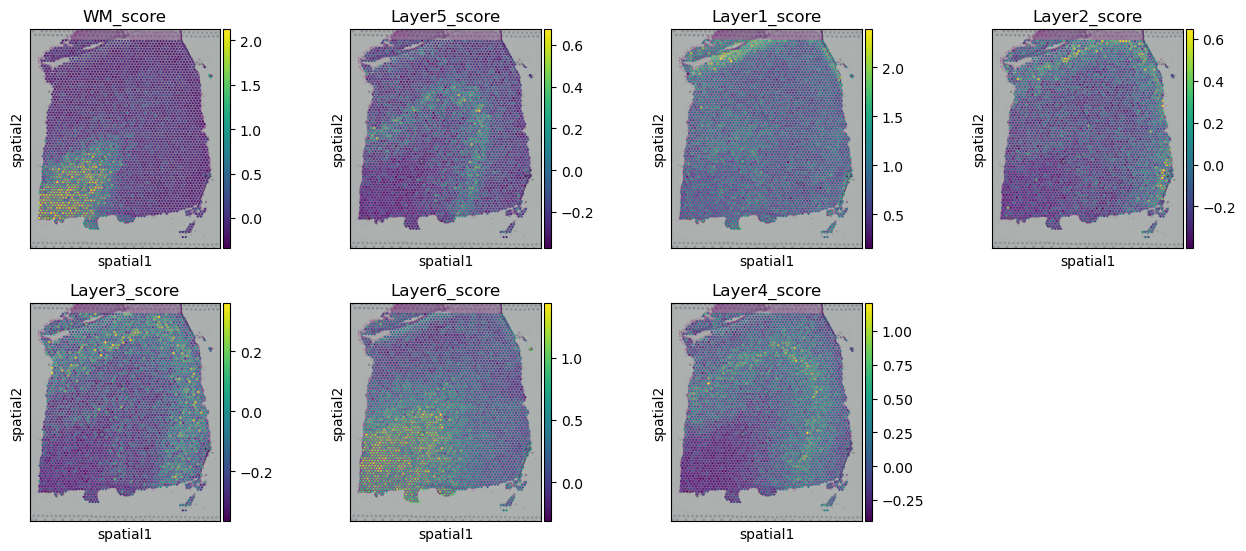

In [6]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.spatial(data, color = [f'{g}_score' for g in group_names])

### Generate inputs for imputation

In [7]:
y = data.obs[[f'{g}_score' for g in group_names]].to_numpy()
y = torch.tensor(y).float()
coords = data.obsm['spatial']

#### Generate spatial loss

By default spatial weight matrix is symmetric (a requirement for the CAR and ICAR models).

In [8]:
# calculate spatial weight matrix
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, k=6)

# convert spatial weight into loss
spatial_loss = SpatialLoss('icar', weights, rho=0.99, standardize_cov=True)

Number of spots: 3639. Average number of neighbors per spot:  5.85.


### Spatial feature smoothing (no missing data)

In [9]:
y_obs = y.clone()
m = ImputeConvex(y_obs, spatial_loss, fixed_obs = False, nonneg=False, lambda_spatial_loss = 1)
y_imp = m.get_results()

=== Time  0.27s. Loss: (total)  0.019, (recon)  0.009, (spatial)  0.010


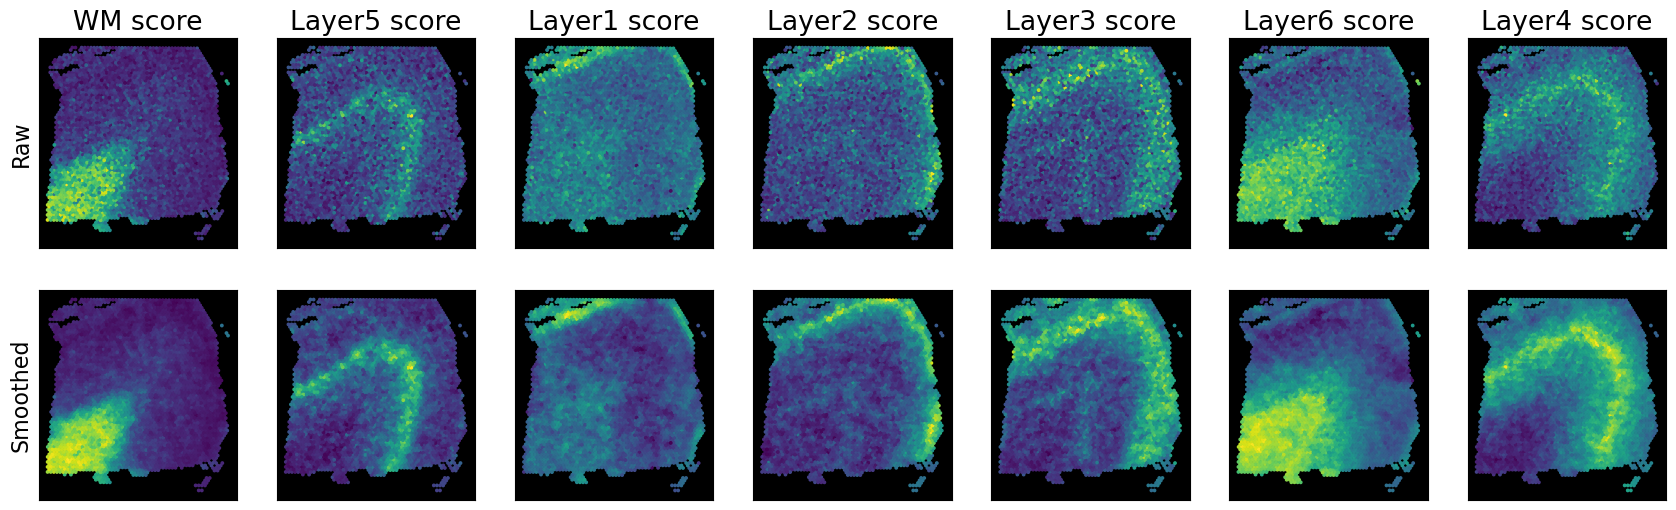

In [10]:
with plt.rc_context({'font.size': 16}):
    fig, axs = plt.subplots(ncols=len(group_names), nrows = 2, figsize = [3*len(group_names), 3*2])
    for i, ax_col in enumerate(axs.T):
        ax_col[0].scatter(coords[:,0], - coords[:, 1],
                          c = y_obs[:,i], s = 3)
        ax_col[1].scatter(coords[:,0], - coords[:, 1],
                          c = y_imp[:,i], s = 3)
        ax_col[0].set_title(f'{group_names[i]} score')
        if i == 0:
            ax_col[0].set_ylabel('Raw')
            ax_col[1].set_ylabel('Smoothed')
    
    for ax in axs.flatten():
        ax.set_facecolor('black')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Imputation + smoothing

In [11]:
# keep 2000 observed spots
obs_ind = np.arange(2000)
ms_ind = [i for i in range(y.shape[0]) if i not in obs_ind]

y_obs = y[obs_ind,:].clone()
y_ms = y[ms_ind,:].clone()

# cvxpy is recommended for the speed and accuracy
m = ImputeConvex(y_obs, spatial_loss, fixed_obs = False, nonneg=False, lambda_spatial_loss = 1)
y_imp = m.get_results()

=== Time  0.25s. Loss: (total)  0.016, (recon)  0.005, (spatial)  0.011


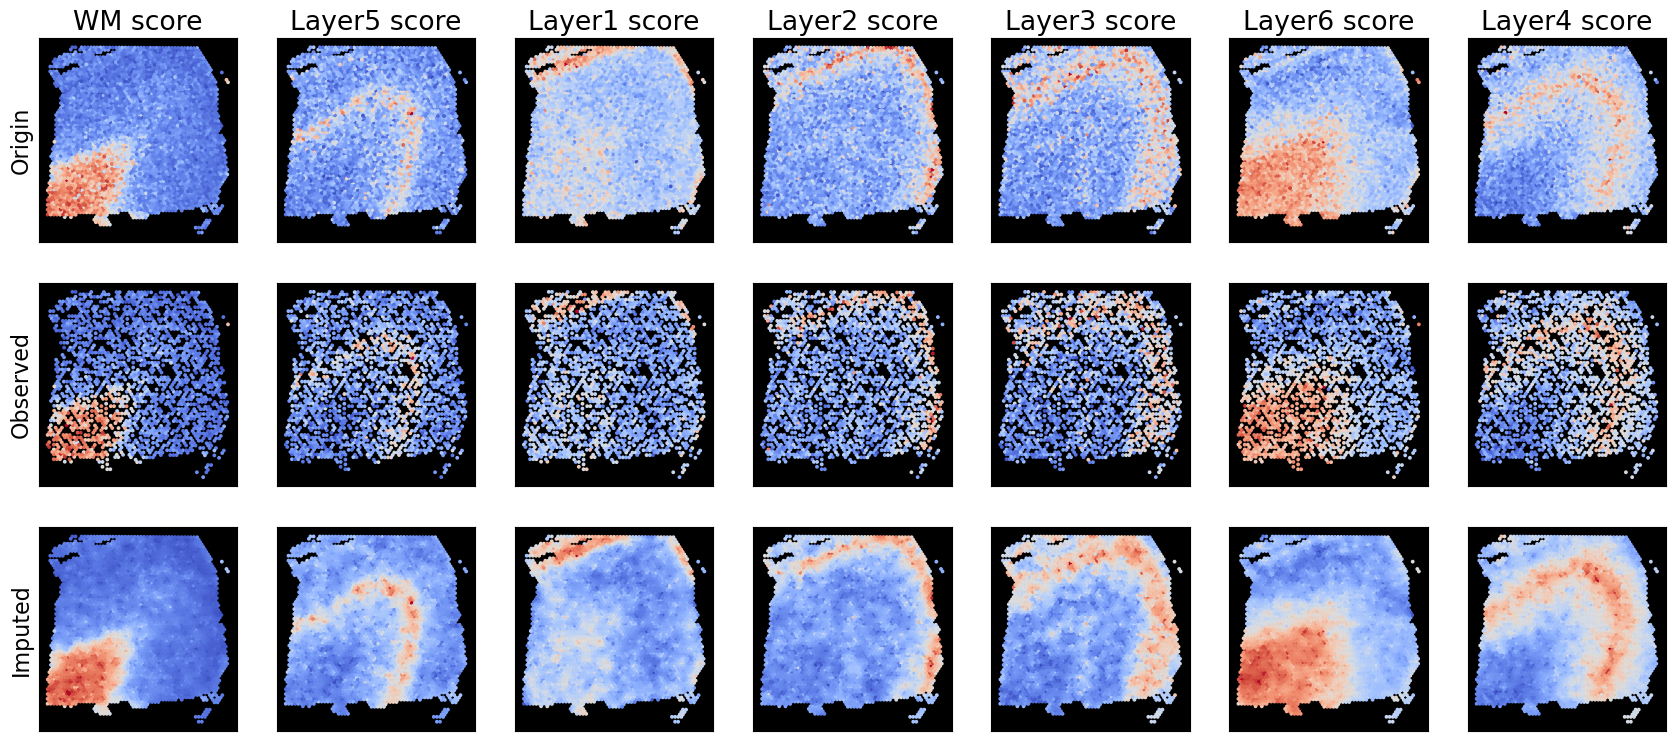

In [12]:
with plt.rc_context({'font.size': 16}):
    fig, axs = plt.subplots(ncols=len(group_names), nrows = 3, figsize = [3*len(group_names), 3*3])
    for i, ax_col in enumerate(axs.T):
        ax_col[0].scatter(coords[:,0], - coords[:, 1],
                          c = y[:,i], s = 3,
                          cmap = "coolwarm")
        ax_col[1].scatter(coords[obs_ind,0], - coords[obs_ind, 1],
                          c = y_obs[:,i], s = 3,
                          cmap = "coolwarm")
        ax_col[2].scatter(coords[:,0], - coords[:, 1],
                          c = y_imp[:,i], s = 3,
                         cmap = "coolwarm")
        ax_col[0].set_title(f'{group_names[i]} score')
        if i == 0:
            ax_col[0].set_ylabel('Origin')
            ax_col[1].set_ylabel('Observed')
            ax_col[2].set_ylabel('Imputed')
    
    for ax in axs.flatten():
        ax.set_facecolor('black')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_2260/1843057283.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)


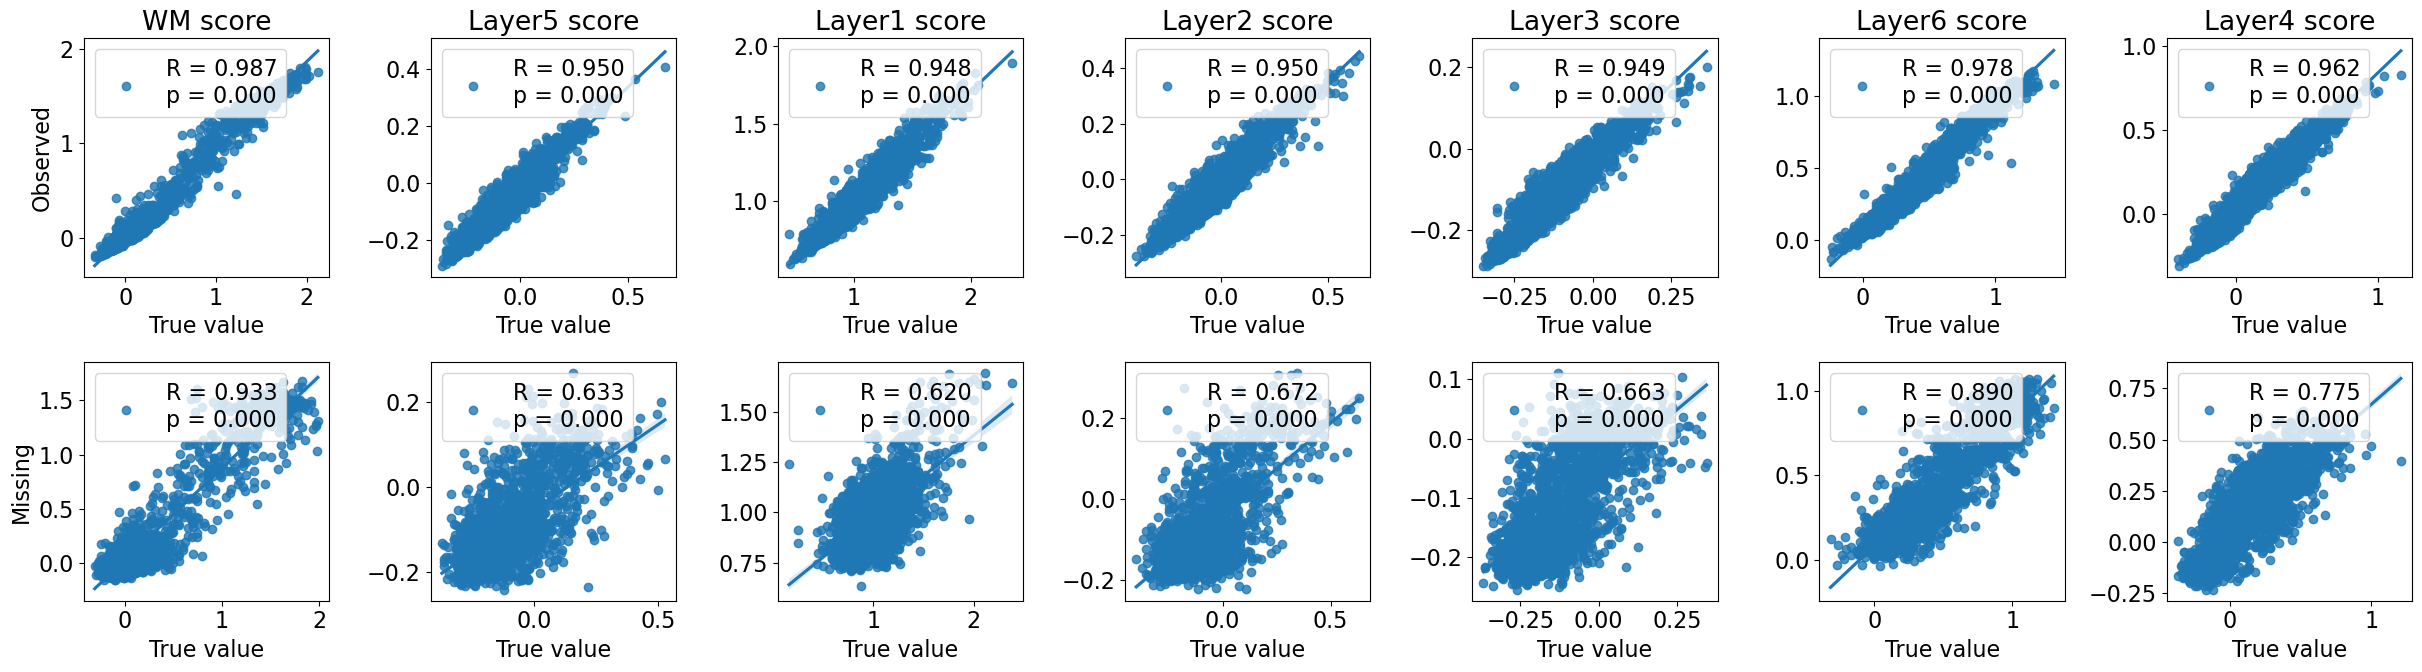

In [13]:
with plt.rc_context({'font.size': 16}):
    fig, axs = plt.subplots(ncols=len(group_names), nrows = 2, figsize = [3.5*len(group_names), 3.5*2])
    for i, ax_col in enumerate(axs.T):
    #     ax_col[0].scatter(y_obs[:,i], y_imp[obs_ind,i], s = 2, alpha = 0.2)
        sns.regplot(x=y_obs[:,i].numpy(), y=y_imp[obs_ind,i], ax=ax_col[0],
                   label=f"R = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[0]:.3f}\n"+
                            f"p = {scipy.stats.pearsonr(y_obs[:,i].T, y_imp[obs_ind,i].T)[1]:.3f}")
        
        ax_col[0].set_title(f'{group_names[i]} score')
    #     ax_col[1].scatter(y_ms[:,i], y_imp[ms_ind,i], s = 2, alpha = 0.2)
        sns.regplot(x=y_ms[:,i].numpy(), y=y_imp[ms_ind,i], ax=ax_col[1],
                   label=f"R = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[0]:.3f}\n"+
                            f"p = {scipy.stats.pearsonr(y_ms[:,i].T, y_imp[ms_ind,i].T)[1]:.3f}")
        
        if i == 0:
            ax_col[0].set_ylabel('Observed')
            ax_col[1].set_ylabel('Missing')
    
    for ax in axs.flatten():
        ax.set_xlabel('True value')
        ax.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

### Imputation with different percentages of missing spots

In [14]:
percentages = [0.01, 0.02, 0.05, 0.10, 0.20]
y_obses = []
y_mses = []
y_impes = []
obs_inds = []
ms_inds = []
for percentage in percentages:
    np.random.seed(0)
    obs_ind = np.arange(int(np.floor((1-percentage)*y.shape[0])))
    ms_ind = [i for i in range(y.shape[0]) if i not in obs_ind]
    y_obs = y[obs_ind, :].clone()
    y_ms = y[ms_ind, :].clone()

    # cvxpy is recommended for the speed and accuracy
    m = ImputeConvex(y_obs, spatial_loss, fixed_obs = False, nonneg=False, lambda_spatial_loss = 1)
    y_impes.append(m.get_results())
    y_obses.append(y_obs)
    y_mses.append(y_ms)
    obs_inds.append(obs_ind)
    ms_inds.append(ms_ind)

=== Time  0.27s. Loss: (total)  0.019, (recon)  0.009, (spatial)  0.010
=== Time  0.26s. Loss: (total)  0.019, (recon)  0.009, (spatial)  0.010
=== Time  0.26s. Loss: (total)  0.019, (recon)  0.008, (spatial)  0.011
=== Time  0.25s. Loss: (total)  0.019, (recon)  0.008, (spatial)  0.011
=== Time  0.25s. Loss: (total)  0.018, (recon)  0.007, (spatial)  0.011


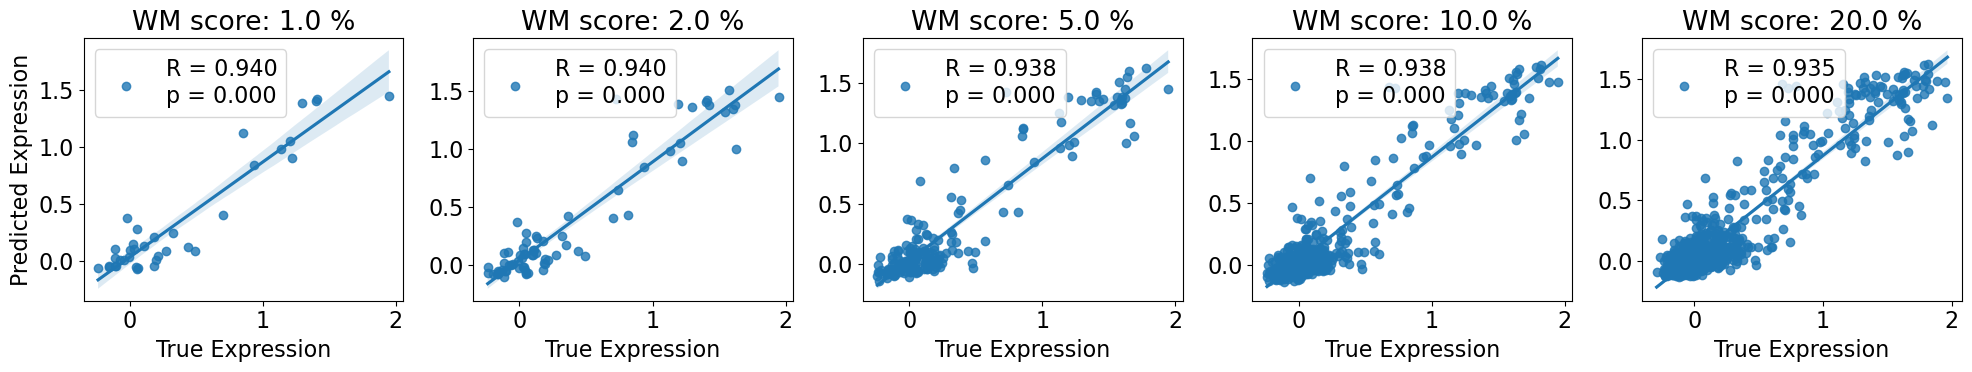

In [15]:
with plt.rc_context({'font.size': 16}):
    fig, axs = plt.subplots(ncols=len(percentages), nrows = 1, figsize = [4*len(percentages), 4*1])
    f_ind = 0
    for i, ax_col in enumerate(axs.T):
        sns.regplot(
            x=y_mses[i][:,f_ind].numpy(), y=y_impes[i][ms_inds[i],f_ind], 
            label=f"R = {scipy.stats.pearsonr(y_mses[i][:,f_ind], y_impes[i][ms_inds[i],f_ind])[0]:.3f}\n" +
                  f"p = {scipy.stats.pearsonr(y_mses[i][:,f_ind], y_impes[i][ms_inds[i],f_ind])[1]:.3f}",
            ax=ax_col
        )
        ax_col.set_title(f"{group_names[f_ind]} score: {percentages[i] * 100} %")
        if i == 0:
            ax_col.set_ylabel('Predicted Expression')
    
    for ax in axs.flatten():
        ax.set_xlabel('True Expression')
        ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

### Increase resolution by percentage

In [27]:
from sklearn.neighbors import NearestNeighbors

def insert_coords(origin_coords, radius = 200):
    # use sklearn to find the nearest neighbors
    nbrs = NearestNeighbors(radius=radius, metric='euclidean').fit(origin_coords)
    indices = nbrs.radius_neighbors(origin_coords, return_distance=False)
    neighbor_index = [[i, j] for i in range(len(indices)) for j in indices[i] if j!= i]
    
    inserted_coords = []
    for s1, s2 in neighbor_index:
        new_coord = (origin_coords[s1, :] + origin_coords[s2, :])/2
        inserted_coords.append(new_coord)

    inserted_coords = np.stack(inserted_coords)
    inserted_coords = np.unique(inserted_coords, axis=0)

    return inserted_coords

In [28]:
# Crop a smaller region for resolution enhancement
keep_row = (coords[:, 0] > np.quantile(coords[:, 0], 0.3)) & \
    (coords[:, 0] < np.quantile(coords[:, 0], 0.6))
keep_col = (coords[:, 1] > np.quantile(coords[:, 1], 0.3)) & \
    (coords[:, 1] < np.quantile(coords[:, 1], 0.6))
coords_truncated = coords[keep_row & keep_col, :]
y_truncated = y[keep_row & keep_col, :]

y_truncated.shape

torch.Size([311, 7])

In [45]:
coords_list = [coords_truncated]
radius_list = [200, 70, 35]

for i in range(3): 
    new_coords = insert_coords(coords_list[i], radius=radius_list[i])
    new_coords = np.concatenate([coords_list[i], new_coords], 0)
    coords_list.append(new_coords)

In [46]:
coords_list[3].shape

(17909, 2)

In [48]:
y_imp_list = []
k_list = [6, 6, 6]
for i, coords_i in enumerate(coords_list):
    if i == 0:
        y_imp_list.append(y_truncated)
        continue

    # calculate resolution increased spatial weight matrix
    weights = SpatialWeightMatrix()
    weights.calc_weights_knn(coords_i, k=k_list[i-1], row_scale=False)

    # convert spatial weight into loss
    # skip the standardization process
    spatial_loss = SpatialLoss('icar', weights, rho=0.99, standardize_cov=False)
    spatial_loss.standardize_cov = True
    
    m = ImputeConvex(y_imp_list[i-1], spatial_loss, fixed_obs = True, nonneg=False, lambda_spatial_loss = 1)
    y_imp = m.get_results()
    y_imp_list.append(y_imp)

Number of spots: 1172. Average number of neighbors per spot:  5.77.
=== Time  0.08s. Loss: (total)  0.038, (recon)  0.000, (spatial)  0.038
Number of spots: 4547. Average number of neighbors per spot:  5.88.
=== Time  0.24s. Loss: (total)  0.018, (recon)  0.000, (spatial)  0.018
Number of spots: 17909. Average number of neighbors per spot:  5.94.
=== Time  1.37s. Loss: (total)  0.014, (recon)  0.000, (spatial)  0.014


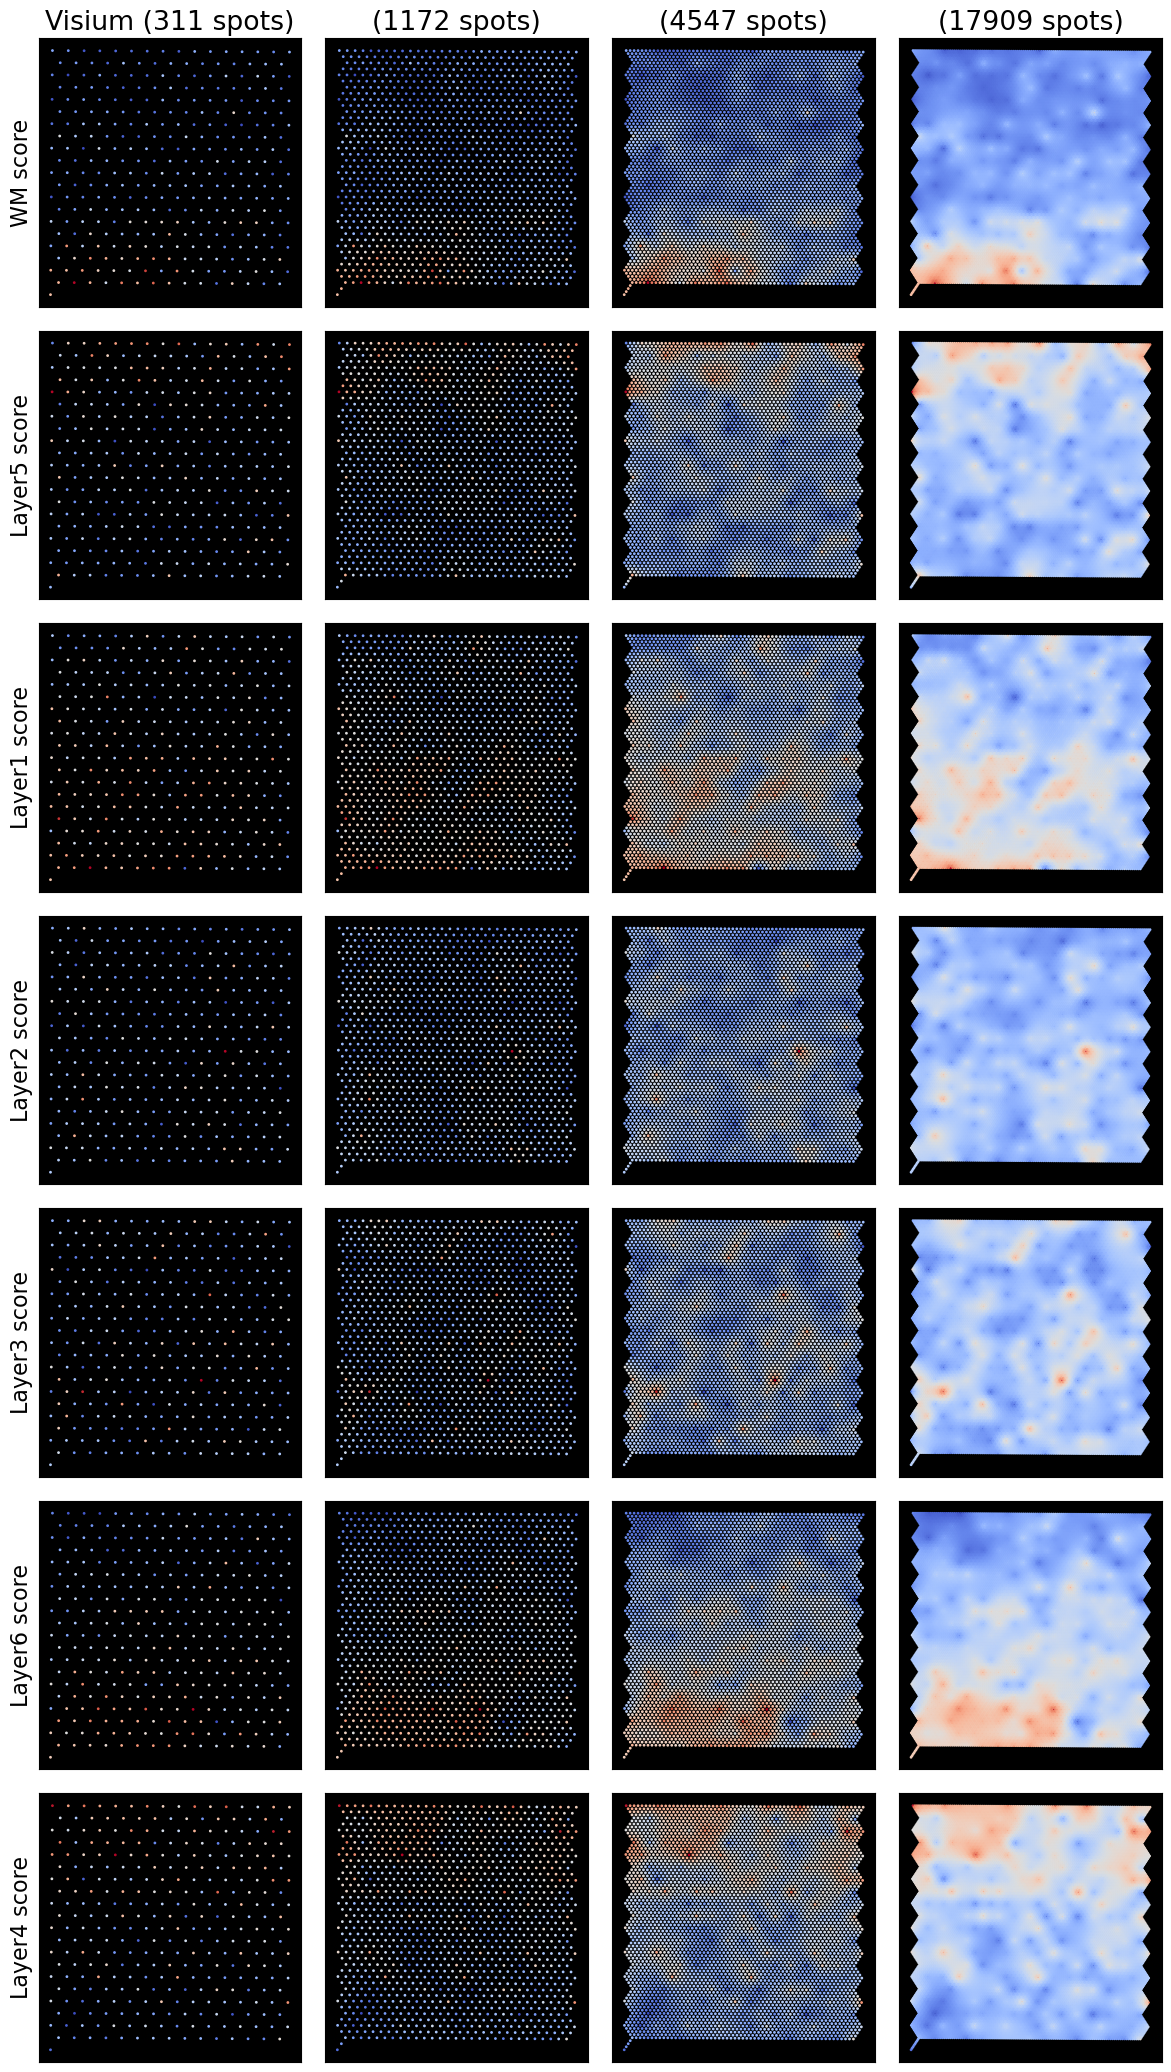

In [52]:
#resolution_names = ['Original (311 spots)', '6x (2033 spots)', '76x (23867 spots)', '']
with plt.rc_context({'font.size': 16}):
    fig, axs = plt.subplots(nrows=len(group_names), 
                            ncols = len(coords_list), 
                            figsize = [3*(len(coords_list)), 3*len(group_names)])
    for i, ax_row in enumerate(axs):
        ax_row[0].set_ylabel(f'{group_names[i]} score')

        for j, ax_row_col in enumerate(ax_row):
            ax_row_col.scatter(
                coords_list[j][:, 0]*4, - coords_list[j][:, 1]*4,
                c = y_imp_list[j][:,i], s = 1,
                cmap = "coolwarm"
            )
            if i == 0:
                if j == 0:
                    ax_row_col.set_title(f'Visium ({coords_list[j].shape[0]} spots)')
                else:
                    ax_row_col.set_title(f'({coords_list[j].shape[0]} spots)')
    
    for ax in axs.flatten():
        ax.set_facecolor('black')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()